In [1]:
!nvidia-smi

Fri Mar 10 10:26:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
!pip install -q tensorflow==2.11.0
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.2 MB/s eta 0:00:00


In [3]:
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import numpy as np
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import mixed_precision
from typing import Tuple
from matplotlib import pyplot as plt

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

AUTO = tf.data.AUTOTUNE

# Configurations

In [5]:
config = {
    "mixed_precision": True,
    "dataset": "cifar10",
    "train_slice": 40_000,
    "batch_size": 1024,
    "buffer_size": 1024 * 2,
    "input_shape": [32, 32, 3],
    "image_size": 48,
    "num_classes": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "epochs": 20,
    "patch_size": 4,
    "embed_dim": 128,
    "chunk_size": 8,
    "r": 2,
    "num_layers": 4,
    "ffn_drop": 0.1,
    "attn_drop": 0.1,
    "num_heads": 1,
}

In [6]:
print(tf.__version__)

2.11.0


In [7]:
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

# Datasets

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:config["train_slice"]], y_train[:config["train_slice"]]),
    (x_train[config["train_slice"]:], y_train[config["train_slice"]:]),
)

170498071/170498071 [==============================] - 2s 0us/step


In [9]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(config["input_shape"][0] + 20, config["input_shape"][0] + 20, dtype="float32"),
        layers.RandomCrop(config["image_size"], config["image_size"], dtype="float32"),
        layers.RandomFlip("horizontal", dtype="float32"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(config["image_size"], config["image_size"], dtype="float32"),
    ],
    name="test_data_augmentation",
)

In [10]:
def train_map_fn(image, label):
    return train_aug(image), label

def test_map_fn(image, label):
    return test_aug(image), label

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(
        train_map_fn, num_parallel_calls=AUTO
    )
    .shuffle(config["buffer_size"])
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [12]:
total_batches_train = tf.data.experimental.cardinality(
    train_ds
).numpy()
total_batches_train 

40

In [13]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(1024, 48, 48, 3)
(1024, 1)


# PatchEmbedding

In [14]:
class PatchEmbed(layers.Layer):
    """Image patch embedding layer.

    Args:
        image_size (Tuple[int]): Input image resolution.
        patch_size (Tuple[int]): Patch spatial resolution.
        embed_dim (int): Embedding dimension.
        add_pos_info (bool): Whether to add positional information to tokens.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (48, 48),
        patch_size: Tuple[int] = (4, 4),
        embed_dim: int = 32,
        chunk_size: int = 8,
        **kwargs,
    ):
        super().__init__(**kwargs)
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]
        self.proj = layers.Conv2D(
            filters=embed_dim, kernel_size=patch_size, strides=patch_size
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=embed_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)
        self.norm = keras.layers.LayerNormalization(epsilon=1e-5)
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches//chunk_size, chunk_size, embed_dim)
        )

    def call(self, x: tf.Tensor) -> Tuple[tf.Tensor, int, int, int]:
        """Patchifies the image, converts into tokens and adds pos information.

        Args:
            x: Tensor of shape (B, H, W, C)

        Returns:
            A tuple of the processed tensor, height of the projected
            feature map, width of the projected feature map, number
            of channels of the projected feature map.
        """
        # Project the inputs.
        x = self.proj(x)
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # B, H, W, C -> B, H*W, C
        x = self.norm(x)

        # Chunk the tokens in K
        x = self.chunking_layer(x)

        return x

# FFN

In [15]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.

    Args:
        dims (`int`): Dimension of the FFN.
        dropout (`float`): Dropout probability of FFN.
    """

    def __init__(self, dims: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4*dims, activation=tf.nn.gelu),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ]
        )
        self.add = layers.Add()
        self.layernorm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, inputs: tf.Tensor):
        x = self.layernorm(inputs)
        x = self.add([inputs, self.ffn(x)])
        return x

# Attention

In [16]:
class BaseAttention(layers.Layer):
    """The base attention module.
    
    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        dropout (`float`): Dropout probability for Attention Module.
    
    """

    def __init__(self, num_heads: int, key_dim: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)
        self.q_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.k_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.v_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.add = layers.Add()

    def call(self, input_query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        query = self.q_layernorm(input_query)
        key = self.k_layernorm(key)
        value = self.v_layernorm(value)
        (attn_outs, attn_scores) = self.mha(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )
        self.attn_scores = attn_scores
        x = self.add([input_query, attn_outs])
        return x

In [17]:
class AttentionWithFFN(layers.Layer):
    """Self-attention module with FFN

    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.attention = BaseAttention(num_heads, key_dim, attn_dropout, name="BaseAttention")
        self.ffn = FeedForwardNetwork(ffn_dims, ffn_dropout, name="FeedForward")
        
    
    def call(self, query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        x = self.attention(query, key, value)
        self.attn_scores = self.attention.attn_scores
        x = self.ffn(x)
        return x

# Recurrence

In [18]:
class CustomCell(layers.Layer):
    """Custom logic inside each recurrence.

    Args:
        chunk_size (`int`): Chunk size of the inputs.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers in the Perceptual Model.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """
    def __init__(
        self,
        chunk_size,
        r=2,
        num_layers: int = 5,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        self.state_size = tf.TensorShape([chunk_size, ffn_dims])
        self.output_size = tf.TensorShape([chunk_size, ffn_dims])

        self.get_attn_scores = False
        self.attn_scores = []

        ########################################################################
        # Perceptual Module
        ########################################################################
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_SelfAttentionFFN{layer_idx}")
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_CrossAttentionFFN{layer_idx}")
                )
        self.perceptual_module = perceptual_module

        ########################################################################
        # Temporal Latent Bottleneck Module
        ########################################################################
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout, 
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"TLBM_CrossAttentionFFN"
        )

    def call(self, inputs, states, training=None):
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]

        slow_stream = states[0]
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(
                query=fast_stream,
                key=fast_stream,
                value=fast_stream
            )
            
            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream,
                    key=slow_stream,
                    value=slow_stream
                )
        
        slow_stream = self.tlb_module(
            query=slow_stream,
            key=fast_stream,
            value=fast_stream
        )

        if self.get_attn_scores:
            self.attn_scores.append(self.tlb_module.attn_scores)
        
        return fast_stream, [slow_stream]

# Build the model

In [19]:
class ModelTrainer(keras.Model):
    def __init__(self, patch_layer, custom_cell, **kwargs):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.rnn = layers.RNN(custom_cell)
        self.gap = layers.GlobalAveragePooling1D()
        self.head = layers.Dense(10, activation="softmax", dtype="float32")
    
    def call(self, inputs):
        x = self.patch_layer(inputs)
        x = self.rnn(x)
        x = self.gap(x)
        outputs = self.head(x)
        return outputs

In [20]:
keras.backend.clear_session()

# PATCH
patch_layer = PatchEmbed(
    image_size=(config["image_size"], config["image_size"]),
    patch_size=(config["patch_size"], config["patch_size"]),
    embed_dim=config["embed_dim"],
    chunk_size=config["chunk_size"],
)

# RECURRENCE
cell = CustomCell(
    chunk_size=config["chunk_size"],
    r=config["r"],
    num_layers=config["num_layers"],
    ffn_dims=config["embed_dim"],
    ffn_dropout=config["ffn_drop"], 
    num_heads=config["num_heads"],
    key_dim=config["embed_dim"],
    attn_dropout=config["attn_drop"],
)


model = ModelTrainer(patch_layer, cell)

In [21]:
run = wandb.init(
    project="temporal-latent-bottleneck",
    entity="ariG23498",
    config=config
)

optimizer = AdamW(
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"]
)
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(
        filepath="model_{epoch:02d}",
        save_freq=int(10 * total_batches_train),
    ),
]
# Compile and train the model.
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    validation_data=val_ds,
    callbacks=wandb_callbacks,
)

run.finish()

wandb: Currently logged in as: arig23498. Use `wandb login --relogin` to force relogin


Epoch 1/20
40/40 [==============================] - 149s 2s/step - loss: 2.8726 - accuracy: 0.1410 - val_loss: 2.1595 - val_accuracy: 0.2032
Epoch 2/20
40/40 [==============================] - 55s 1s/step - loss: 2.1116 - accuracy: 0.2218 - val_loss: 2.0413 - val_accuracy: 0.2393
Epoch 3/20
40/40 [==============================] - 55s 1s/step - loss: 2.0046 - accuracy: 0.2645 - val_loss: 1.9883 - val_accuracy: 0.2834
Epoch 4/20
40/40 [==============================] - 55s 1s/step - loss: 1.9477 - accuracy: 0.2937 - val_loss: 1.9419 - val_accuracy: 0.3073
Epoch 5/20
40/40 [==============================] - 55s 1s/step - loss: 1.8946 - accuracy: 0.3098 - val_loss: 1.8897 - val_accuracy: 0.3345
Epoch 6/20
40/40 [==============================] - 55s 1s/step - loss: 1.8288 - accuracy: 0.3380 - val_loss: 1.7624 - val_accuracy: 0.3681
Epoch 7/20
40/40 [==============================] - 55s 1s/step - loss: 1.7547 - accuracy: 0.3620 - val_loss: 1.7440 - val_accuracy: 0.3729
Epoch 8/20
40/40 [=

wandb: Adding directory to artifact (./model_10)... Done. 0.1s


40/40 [==============================] - 98s 2s/step - loss: 1.5820 - accuracy: 0.4232 - val_loss: 1.5693 - val_accuracy: 0.4324
Epoch 11/20
40/40 [==============================] - 55s 1s/step - loss: 1.5286 - accuracy: 0.4425 - val_loss: 1.5468 - val_accuracy: 0.4421
Epoch 12/20
40/40 [==============================] - 55s 1s/step - loss: 1.4981 - accuracy: 0.4540 - val_loss: 1.4856 - val_accuracy: 0.4572
Epoch 13/20
40/40 [==============================] - 55s 1s/step - loss: 1.4625 - accuracy: 0.4674 - val_loss: 1.4432 - val_accuracy: 0.4819
Epoch 14/20
40/40 [==============================] - 53s 1s/step - loss: 1.4311 - accuracy: 0.4761 - val_loss: 1.5189 - val_accuracy: 0.4646
Epoch 15/20
40/40 [==============================] - 55s 1s/step - loss: 1.3998 - accuracy: 0.4915 - val_loss: 1.4384 - val_accuracy: 0.4840
Epoch 16/20
40/40 [==============================] - 55s 1s/step - loss: 1.3816 - accuracy: 0.4992 - val_loss: 1.3998 - val_accuracy: 0.4913
Epoch 17/20
40/40 [======

wandb: Adding directory to artifact (./model_20)... Done. 0.1s


40/40 [==============================] - 100s 2s/step - loss: 1.2834 - accuracy: 0.5348 - val_loss: 1.2825 - val_accuracy: 0.5408


epoch/accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▇▆▇▇▇▇██
epoch/val_loss,█▇▇▆▆▅▅▄▃▃▃▃▂▃▂▂▂▂▁▁
epoch/accuracy,0.5348
epoch/epoch,19
epoch/learning_rate,0.0001
epoch/loss,1.28342
epoch/val_accuracy,0.5408


# Testing

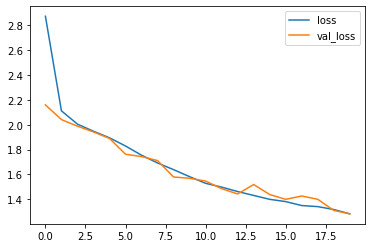

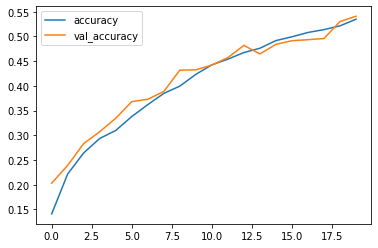

In [22]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

# Visualize the Latent Bottleneck

In [23]:
model.rnn.cell.attn_scores = []

In [24]:
images, labels = next(iter(test_ds))

# Set the flag for attn score
model.rnn.cell.get_attn_scores = True
outputs = model(images)

In [25]:
# Grab the list of chunk scores
list_chunk_scores = model.rnn.cell.attn_scores

In [26]:
def score_to_viz(chunk_score):
    chunk_viz = tf.math.reduce_max(chunk_score, axis=-2) # get the most attended token
    chunk_viz = tf.math.reduce_mean(chunk_viz, axis=1) # get the mean across heads
    return chunk_viz

In [27]:
list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores]

In [29]:
chunk_viz = tf.concat(list_chunk_viz[1:], axis=-1)
chunk_viz = tf.reshape(
    chunk_viz,
    (config["batch_size"], config["image_size"]//config["patch_size"], config["image_size"]//config["patch_size"], 1)
)

In [30]:
upsampled_heat_map = layers.UpSampling2D(
    size=(4, 4),
    interpolation='bilinear',
    dtype="float32"
)(chunk_viz)

In [35]:
index = 50
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

print(orig_image.dtype)
print(overlay_image.dtype)

<dtype: 'float32'>
<dtype: 'float32'>


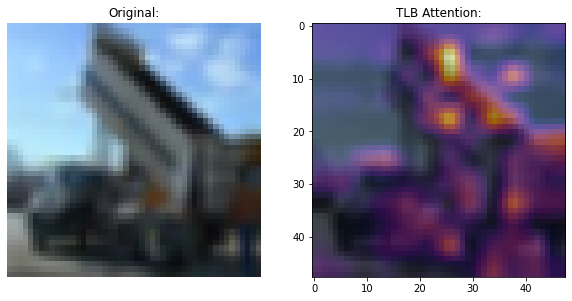

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(
    overlay_image,
    cmap="inferno",
    alpha=0.6,
    extent=image.get_extent(),
)
ax[1].set_title("TLB Attention:")

plt.show()